In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 100

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5259,2024-03-23 17:44:10.530000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzgdppczq6g0081hjfg,"[Subset 52, 100 rounds, 0 log, xbasis=False]",1.0,768.0,NaN,JobStatus.DONE,2024-03-23 18:05:17.770180+01:00,RepetitionCodeCircuit,52,100,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.008345314216382, 'min_ga..."
5258,2024-03-23 17:43:48.780000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzgdh6ktf3g00883tn0,"[Subset 52, 100 rounds, 0 log, xbasis=False]",1.0,768.0,NaN,JobStatus.DONE,2024-03-23 18:04:47.231991+01:00,RepetitionCodeCircuit,52,100,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.008345314216382, 'min_ga..."


In [3]:
from result_saver import SaverProvider

provider = SaverProvider()
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 18:05:17.770180+01:00


In [4]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

In [5]:
from Scratch import load_calibration_memory

all_memories_PS, _, msmt_err_dict = load_calibration_memory(provider, tobecalib_job=job_id, post_process=True, double_msmt=True)

Specified job execution date: 2024-03-23 18:05:17.770180+01:00
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 17:06:20.263377+00:00.


# RepCode data pipeline

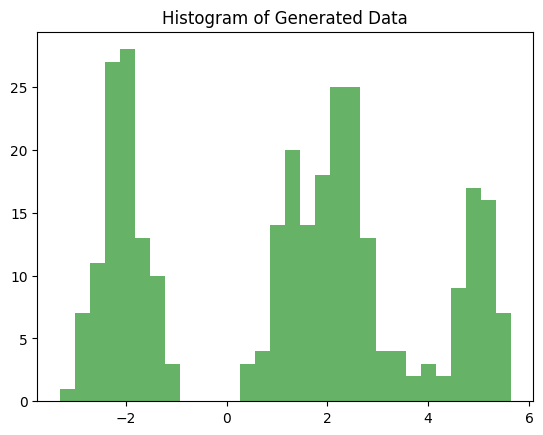

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_synthetic_data():
    np.random.seed(42)
    data1 = np.random.normal(loc=-2, scale=0.5, size=100)
    data2 = np.random.normal(loc=2, scale=0.8, size=150)
    data3 = np.random.normal(loc=5, scale=0.3, size=50)
    data = np.concatenate([data1, data2, data3])
    np.random.shuffle(data)
    return data

data = generate_synthetic_data()

# Plot the histogram of the data
plt.hist(data, bins=30, alpha=0.6, color='g')
plt.title('Histogram of Generated Data')
plt.show()

In [5]:
import pystan

# Stan model code
stan_code = """
// Save this model as 'gmm_model.stan'
data {
    int<lower=0> N;          // Number of data points
    real y[N];               // Data
    int<lower=1> K;          // Number of mixture components
}

parameters {
    simplex[K] theta;        // Mixing proportions
    real mu[K];              // Means of mixture components
    real<lower=0> sigma[K];  // Standard deviations of mixture components
}

model {
    vector[K] log_theta = log(theta);  // Precompute log(theta)
    
    // Priors
    for (k in 1:K) {
        mu[k] ~ normal(0, 10);
        sigma[k] ~ cauchy(0, 2.5);
    }

    // Likelihood
    for (n in 1:N) {
        vector[K] log_component_density;
        for (k in 1:K) {
            log_component_density[k] = log_theta[k] + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        target += log_sum_exp(log_component_density);
    }
}
"""

# Data for Stan model
stan_data = {
    'N': len(data),
    'y': data,
    'K': 3
}

# Compile the model
sm = pystan.StanModel(model_code=stan_code)

In file included from /var/folders/_3/n7zzdff5239886c9gmhrk6yr0000gn/T/pystan_t6s80746/stanfit4anon_model_b948ad48c0bc003a2ddbc78028fe657a_501731474462212646.cpp:1315:
In file included from /Users/mha/.local/share/virtualenvs/Soft-Info-fMUpUe5a/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/mha/.local/share/virtualenvs/Soft-Info-fMUpUe5a/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/mha/.local/share/virtualenvs/Soft-Info-fMUpUe5a/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/mha/.local/share/virtualenvs/Soft-Info-fMUpUe5a/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^
In file included from /var/folder

In [7]:
# Fit the model
fit = sm.sampling(data=stan_data, iter=1000, chains=4)

# Print the results
print(fit)


Process SpawnPoolWorker-1:
Traceback (most recent call last):
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mha/.pyenv/versions/3.11.4/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/mha/.pyenv/versions/3.11.4/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mha/.pyenv/versions/3.11.4/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/mha/.pyenv/versions/3.11.4/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'stanfit4anon_model_b948ad48c0bc003a2ddbc78028fe657a_501731474462212646'
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/Users/mha/.pyenv/versions/3.11.4/lib/python3